# Summary

This notebook walks through the process of analyzing time series data in the neighborhood of "events", in this case the events of interest are specifically windows of time where individuals report experiencing influenza-like illness (ILI). Specifically we are interested in pairing daily features computed via raw data collected from a commercial Fitbit device in order to quantify the impact of ILI on behavior and physiology.


**Learning Objectives:**
1. Combine reported maximal symptom dates with passively measured daily features in order to construct analysis windows for each individual
2. Use time series visualization techniques to better understand individual and population responses to ILI across measurement dimensions
3. Use a fixed effects regression framework to estimate the average ILI impact trajectory in the neighborhood of an ILI event

**Notes**
- For this analysis we will use simulation data rather than actual data pulled from individuals. This is to preserve privacy of individuals. The underlying distribution of features is reasonably similar to what we observe empirically using actual ILI event data.

# Dependencies

We'll be using some standard data analysis libraries for this analysis.

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max.rows', 100)
pd.set_option('max.columns', 100)
sns.set(style='whitegrid')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
data_dir = '/home/bbradshaw/'

# Reading in the data

For this analysis there are two fundamental data components:
1. **User reported events:** This table contains one row per user corresponding to the date where the user reported that their symptoms were at their worst
2. **User Fitbit Features**: This table contains multiple rows per user, corresponding to features derived from raw Fitbit data. There are 29 days per user. In econometric parlance, we would call this a *balanced panel*.

In [4]:
from utils import generate_event_data

In [5]:
# This is a helper that generates the simulated data we'll be using for the analysis
features, events = generate_event_data()

## Doing a quick inspection of the data

Let's take a peek at each of our tables to ensure we have an idea of what sort of data we are dealing with.

In [6]:
# Let's inspect the events table
events.head()

,event_date,user_id
0,2019-02-27,0
1,2019-02-08,1
2,2019-03-04,2
3,2019-03-30,3
4,2019-02-05,4


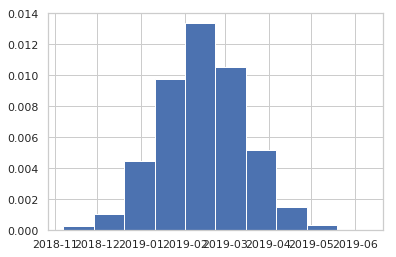

In [7]:
# Let's look at the distribution of reporte ILI event dates
events.event_date.hist(density=True)

It appears that flu season peaked around Februrary. These event dates are simulated and in actuality you wouldn't see such a symmetric "normal" distribution for flu incidence since the rate of increase up until peak flue season likely won't mirror the rate of decrease after the peak.

In [8]:
events.groupby('user_id').size().max(), events.user_id.nunique()

(1, 3000)

As expected, there is one row per user. Next, let's take a look at the features.

In [9]:
features.head()

,user_id,date,steps_sum,sleep_disturbances,resting_heart_rate
0,0,2019-02-13,10682,0,55
1,0,2019-02-14,10788,0,72
2,0,2019-02-15,10789,1,59
3,0,2019-02-16,11620,1,55
4,0,2019-02-17,11782,1,55


There are three features we will be using throughout the analysis:
1. `steps_sum`: The daily sum of steps walked for a user on a given date
2. `sleep_disturbances`: The estimated number of sleep disturbances measured on a given night's sleep
3. `resting_heart_rate`: A user's estimated resting heart rate on a given date

## Aligning user time series to a common distance from event

One of the issues we have here is that we need to "align" the behavioral and physiological features with the event dates reported by users. The idea is that if we know approximately "when" flu events took place, we could then do some investigation of interesting anomolies within the time series surrounding those events.

We'll do precisely that! For each user-date, we will generate a "relative index date" which is simply the integer valued number of days from the reported peak symptom date (negative values imply dates before the reported peak symptom date, positive values after).

In [10]:
# First join each user's event date with features
features = features.merge(events, on='user_id', how='inner')

In [11]:
# Now we have dates and event dates
features.head()

,user_id,date,steps_sum,sleep_disturbances,resting_heart_rate,event_date
0,0,2019-02-13,10682,0,55,2019-02-27
1,0,2019-02-14,10788,0,72,2019-02-27
2,0,2019-02-15,10789,1,59,2019-02-27
3,0,2019-02-16,11620,1,55,2019-02-27
4,0,2019-02-17,11782,1,55,2019-02-27


In [12]:
features['relative_idx'] = (features.date - features.event_date) / pd.Timedelta(days=1)

In [13]:
features.head()

,user_id,date,steps_sum,sleep_disturbances,resting_heart_rate,event_date,relative_idx
0,0,2019-02-13,10682,0,55,2019-02-27,-14.0
1,0,2019-02-14,10788,0,72,2019-02-27,-13.0
2,0,2019-02-15,10789,1,59,2019-02-27,-12.0
3,0,2019-02-16,11620,1,55,2019-02-27,-11.0
4,0,2019-02-17,11782,1,55,2019-02-27,-10.0


Perfect! We now have a `relative_idx` variable that specifies for each user-day observation, how far (in days) that day is from peak symptom severity. The reason we do this is so that we can align the activity data with a cosistent notion of when the event occured across users.

# Preliminary time series analysis: visualization

In general, the best approach to analysis is to start with the simplest possible approach that makes sense. Many times, *plotting* data in a reasonable manner is a great way to get an understanding of te underlying dynamics of the problem at hand. We'll do just that.

Our approach will be as follows:
- For each user create a `relative_idx` column that specifies how far a day is from the peak reporte symptom date (we already did this)
- Plot the mean value across all user time series (for each feature) and use the bootstrap to get an estimate of confidence about the mean
- Take a look at how feature time series change in the neighborhood of ILI events

Let's implement!

/mnt/data0/bbradshaw/python3.5/venv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


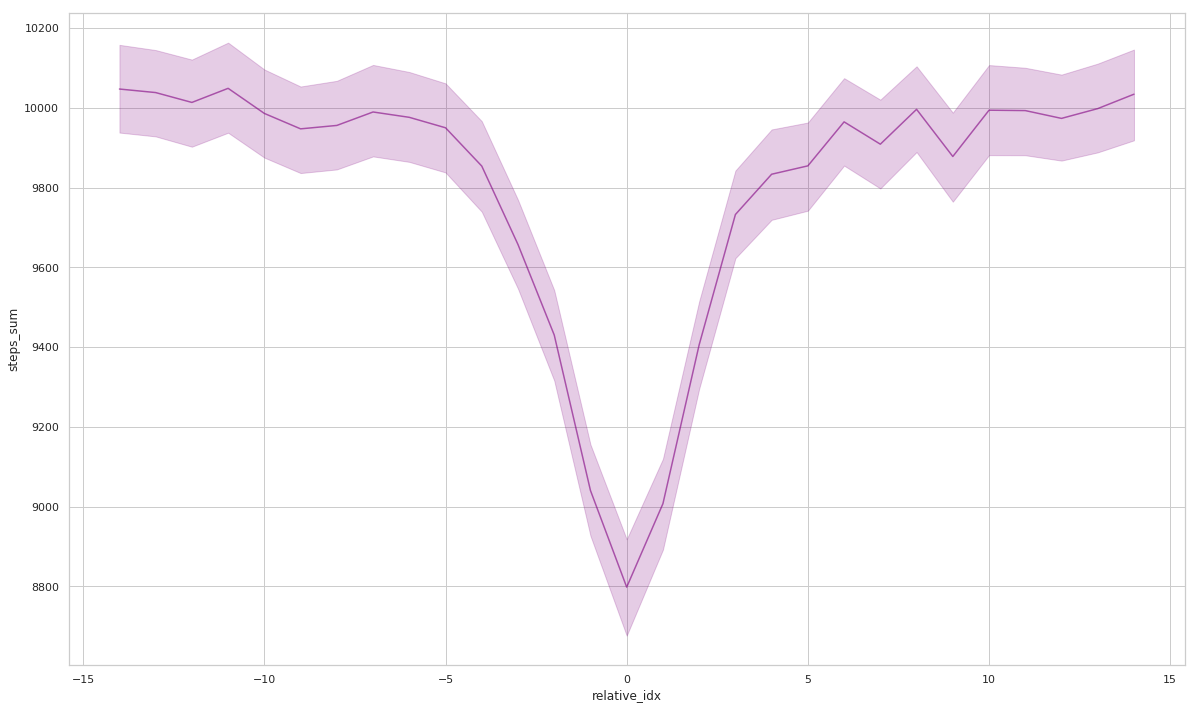

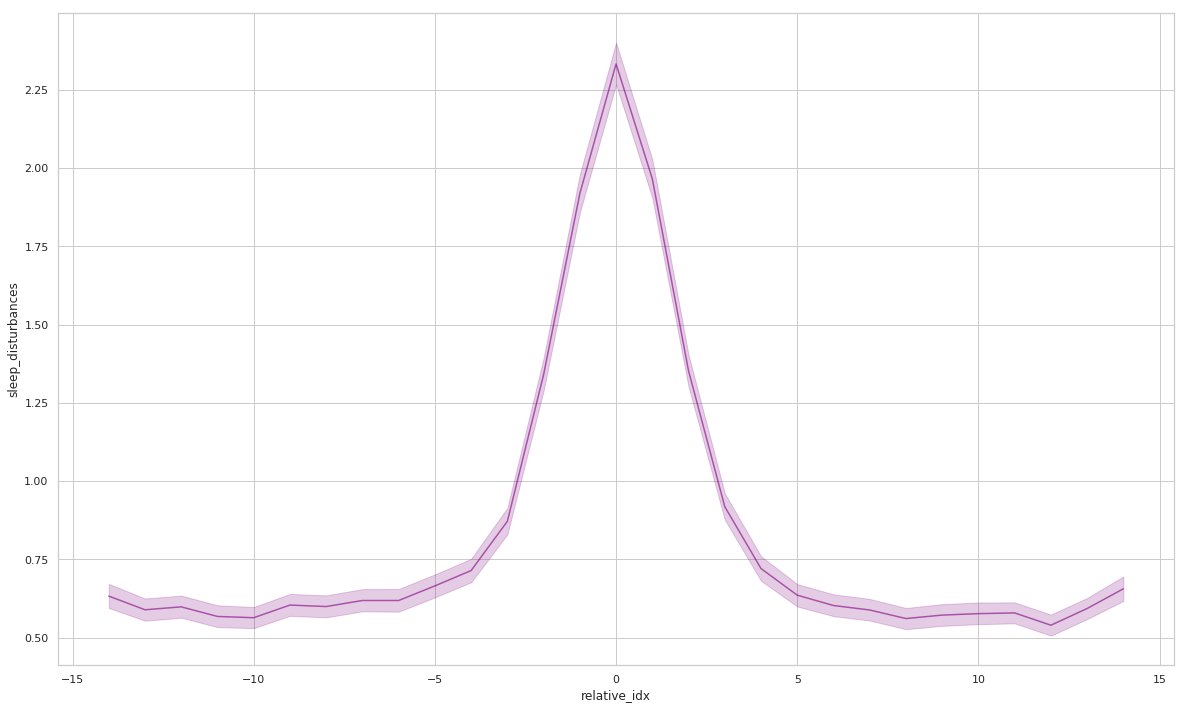

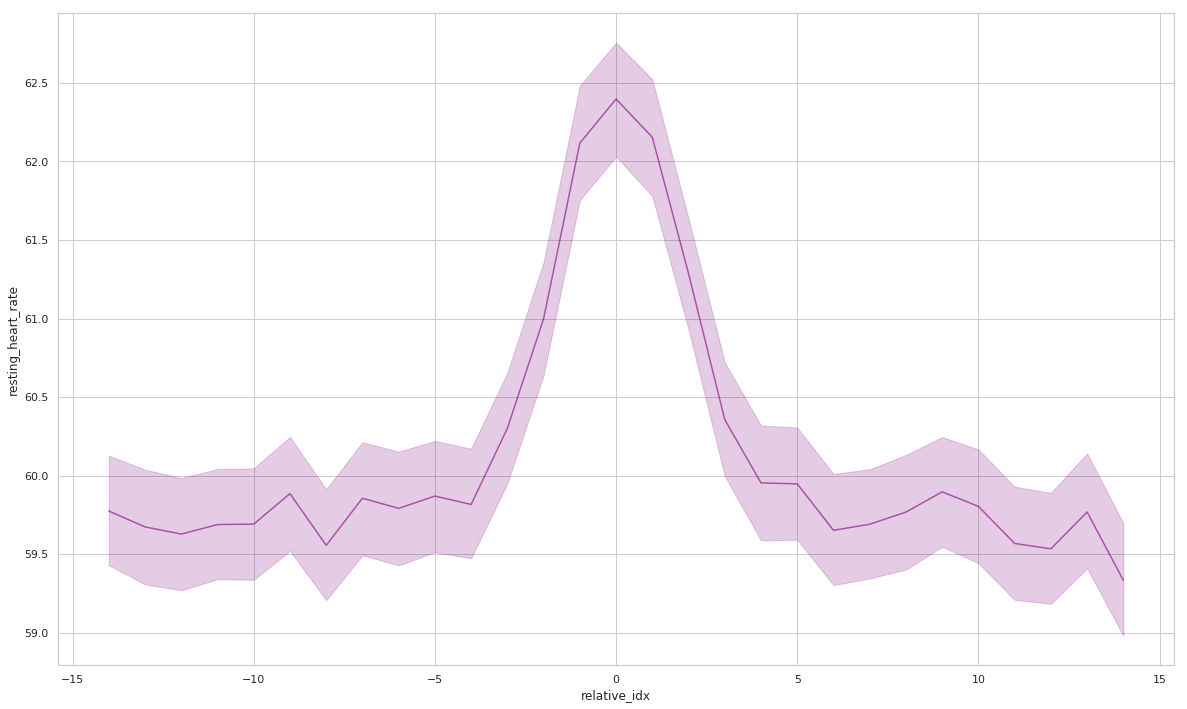

In [14]:
# Seaborn actually makes this quite easy
for f in ['steps_sum', 'sleep_disturbances', 'resting_heart_rate']:
    plt.figure(figsize=(20,12))
    sns.lineplot(x='relative_idx', y=f, data=features, ci=95, n_boot=10000, color='purple', alpha=0.6)

Wow! So there is clearly some signal here. A few observations here:
- Average steps decrease in the neighborhood of a flu event
- Average sleep disturbances increase in the neighborhood of a flu event
- Average resting heart rate increases in the neighborhood of a flu event

Note that here we are making observations about the mean, not about individual responses to ILI. It may be useful to plot a random sample of *individual* time series feature trajectories.

/mnt/data0/bbradshaw/python3.5/venv/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


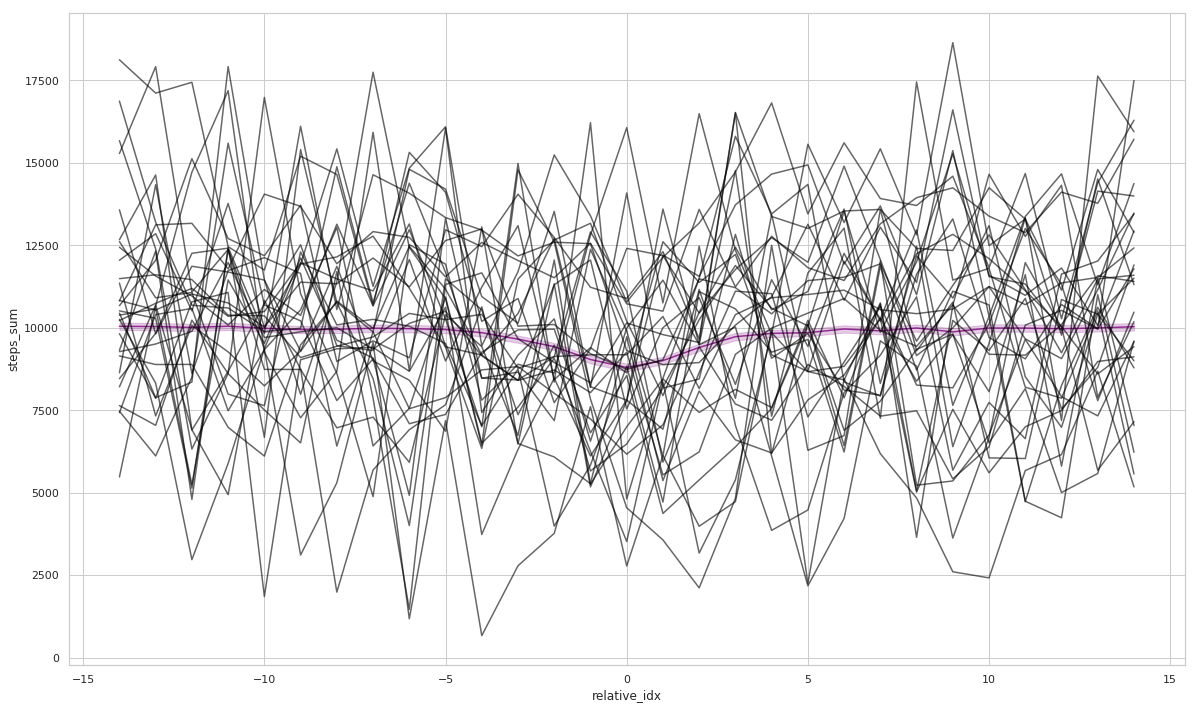

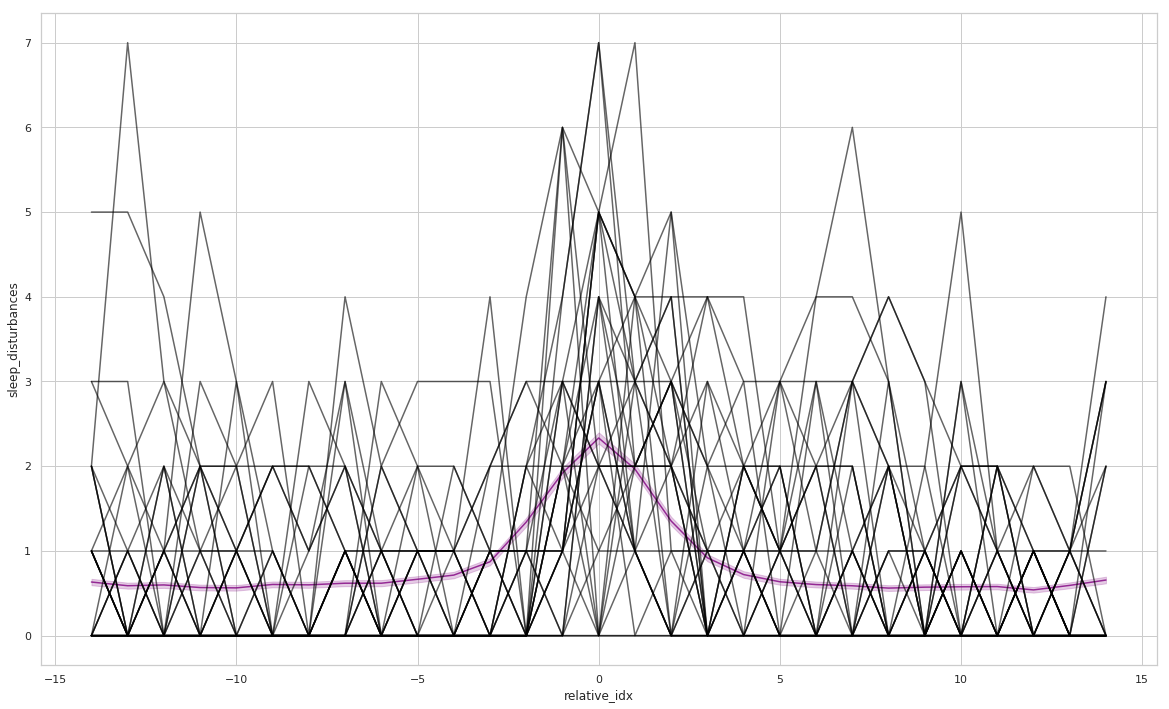

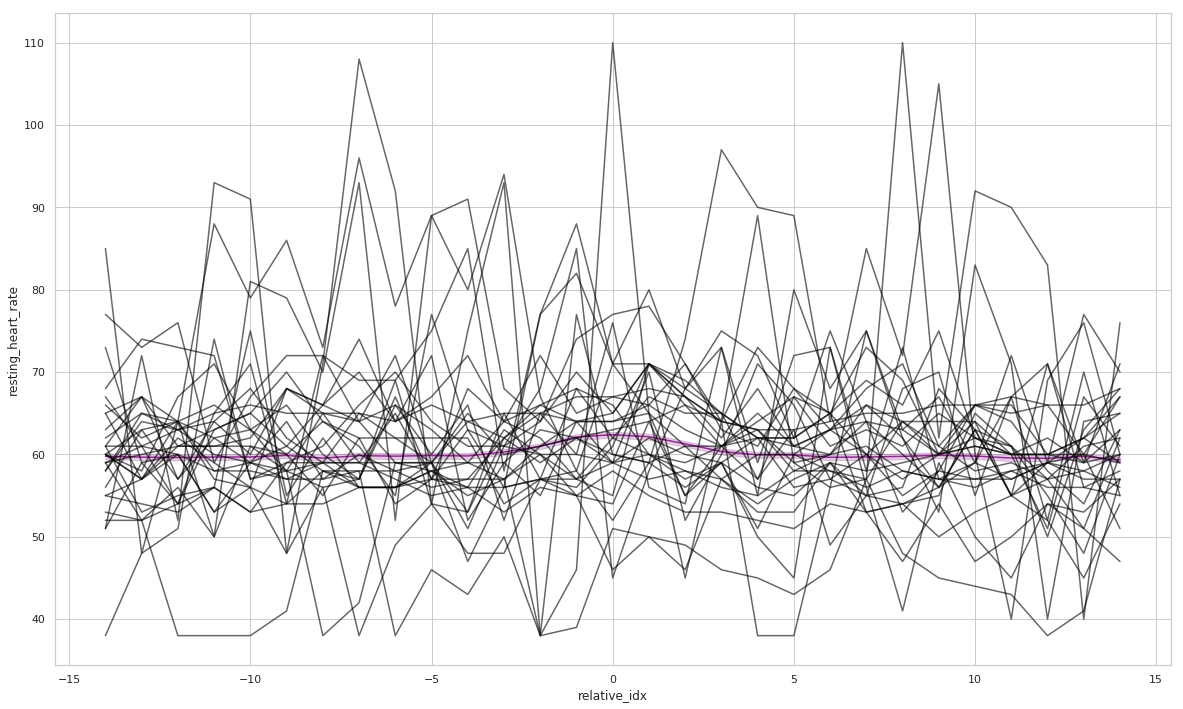

In [15]:
# Seaborn actually makes this quite easy
for f in ['steps_sum', 'sleep_disturbances', 'resting_heart_rate']:
    plt.figure(figsize=(20,12))
    sns.lineplot(
        x='relative_idx',
        y=f,
        data=features,
        ci=95,
        n_boot=10000,
        color='purple',
        alpha=0.8
    )

    sns.lineplot(
        x='relative_idx',
        y=f,
        data=features.merge(events[['user_id']].sample(frac=0.01, random_state=42), on='user_id'),
        color='black',
        alpha=0.6,
        units='user_id',
        estimator=None
    )

One point the above graphs makes is that even though the average of the feature trajectories shows a clear pattern, individual trajectories are quite noisy. This is something to keep in mind if we attempt to build a *prediction* model that attempts to distinguish windows of time containing a flu event from control windows that do not contain a flu event.

# Estimating the impact of ILI events on behavior and physiology: Fixed effects regression

While the bootstrap method above is great for a first pass exploration, it isn't a robust analytically framework that allows us to make strong inferential claims. One way we can model how a feature changes in the neighborhood of an ILI event is to use wht econometricians call "the fixed effects estimator" or the "within estimator" The idea is that since we have multiple measurements per subject, a standard OLS model would be biased since residuals of the model are no longer independent from one another (since blocks of observations are generated from a single individual). We won't go into the details of fixed effects regression modeling (indeed entire classes are taught on the subject). The idea here is that we will model the average value of the feature as a function of distance from peak symtom date, while accounting for unobserved heterogeniety that is fixed at the level of the individual.

Luckily there is already a python library that implements the estimation routine for us: `linearmodels`. We'll use the following model:
$$f_{i,t}= \sum_{d=0}^{T}{\beta_{d}}D_{b, i, t}$$

Where $f_{i,t}$ is the feature of interest (e.g. step sum) at time t, for individual i, and $D_{b,i,t}$ is a binary indicator variable which is 1 if $t=b$, and 0 else.

For the sake of having a concise pedogogical discussion i've implemented a class `PanelEventPlotter` that essentially does all of the above for us and also allows us to make a nice plot of the estimated effect of being distance *d* from the maximal reported symptoms.

In [33]:
from utils import PanelEventPlotter

In [41]:
reg_features = features.copy()

In [42]:
panel_plotter = PanelEventPlotter()

In [46]:
panel_plotter.fit(reg_features, 'steps_sum', weekday_effects=False)

Dep. Variable:,steps_sum,R-squared:,0.0204
Estimator:,PanelOLS,R-squared (Between):,-0.0481
No. Observations:,87000,R-squared (Within):,0.0204
Date:,"Tue, May 21 2019",R-squared (Overall):,-0.0446
Time:,03:43:14,Log-likelihood,-7.97e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,62.559
Entities:,3000,P-value,0.0000
Avg Obs:,29.000,Distribution:,"F(28,83972)"
Min Obs:,29.000,,
Max Obs:,29.000,F-statistic (robust):,58.122


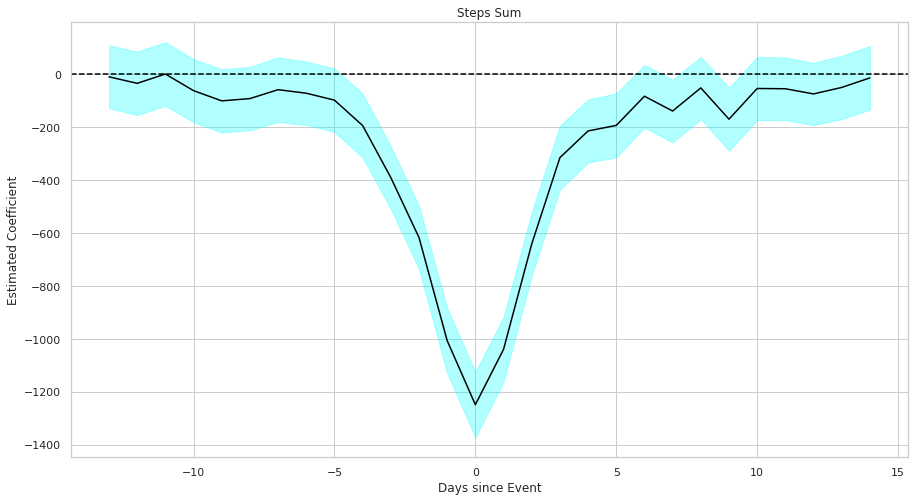

In [48]:
panel_plotter.plot()

# Exercises

##  Exercise 1: Peeking under the hood of the data generating process

For this example notebook I used a funtion: `generate_event_data`. This function uses some basic summations of random variables in order to create simulation data for this notebook.

1. Take a look inside `generate_event_data`. You can inspect the source code by running `generate_event_data??` within a cell of the notebook. You'll find that there isn't any magic here, just heavy use of numpy's built in `random` module as well as some (some may say hacky) heuristics. Try to read through the code and understand what it is doing.
2. Create a new function `generate_control_data` that does the same thing as `generate_event_data` but does not add any "shocks" (i.e. deviations from the individual baseline distribution). This function should return a dataframe that is equivalent to the `features` dataframe returned by `generate_event_data` but individual features should not have been impacted by the exogenous shock applied.

In [47]:
# Your code here. . .

## Exercise 2: Building and event detection system

Suppose you want to build an event detection system to differentiate windows of time that contain flu events from windows of time that do not contain flu events.

1. Use the `generate_event_data` function to generate observations containing a "flu event". Use the `generate_control_data` you constructed in exercise 1 to construct windows that do not contain a flu event.
2. For each user, compute various summary statistics across each feature, for both event and control windows (e.g. mean, min, max, skewness). Plot the distributions of these statistics for each feature between event and control windows. Do you observe any differences? What statistical tests could you apply to test for significant differences between the distributions? The starter code below may help get you going.
3. (For the intrepid) Can you build a machine learning classifier that is tasked with differentiating between event and control windows? How would you go about modelling this problem? What issues do you consider as you begin thinking baout this problem?

In [54]:
def aggregate_user_time_series(df, agg_funcs):
    """Compute summary statistics for each user, across each feature.
    
    Paramters
    ---------
    df : Pandas DataFrame
        Data containing 'user_id', 'steps_sum', 'sleep_disturbances',
        and 'resting_heart_rate' columns
    
    agg_funcs : list(func or str)
        list of functions or string interpretable by pandas df agg method
        
    Returns
    -------
    Aggregated feature dataframe
    """
    agg_features = ['steps_sum', 'sleep_disturbances', 'resting_heart_rate']
    result = df.groupby('user_id').agg({x: agg_funcs for x in agg_features})
    result = result.reset_index()
    result.columns = [x[0]+'_'+x[1] for x in result.columns]
    return result

In [55]:
agg_features = aggregate_user_time_series(features, ['mean', 'std', 'min', 'max'])

In [56]:
# Now we have a new dataframe that is one row per user
agg_features.head()

,user_id_,sleep_disturbances_mean,sleep_disturbances_std,sleep_disturbances_min,sleep_disturbances_max,resting_heart_rate_mean,resting_heart_rate_std,resting_heart_rate_min,resting_heart_rate_max,steps_sum_mean,steps_sum_std,steps_sum_min,steps_sum_max
0,0,1.275862,0.959782,0,3,62.896552,5.918161,52,74,10683.655172,760.991284,9258,12907
1,1,0.724138,0.996299,0,3,65.931034,2.939036,60,73,11724.862069,2998.667486,5752,17666
2,2,0.586207,1.052794,0,4,64.965517,3.364550,57,70,8892.655172,2784.204699,3469,13070
3,3,0.896552,1.291312,0,4,57.344828,11.641293,38,76,9768.862069,960.159575,6614,11123
4,4,0.586207,1.018305,0,4,65.379310,5.185239,56,73,7129.862069,1955.735388,1885,11804
